In [27]:

import trimesh
import os
import torch
import numpy as np

data_folder = "/data/wlsgur4011/DataCollection/BreakingBad/data_split/artifact/73400_sf/mode_5"
file_names = ['piece_0.obj', 'piece_1.obj', 'piece_2.obj']
total_points = 50000
scale = 7


def _knn(src, dst, k=1, is_naive=True):
    """return k nearest neighbors"""
    if len(src) * len(dst) > 10e8:
        # TODO: optimize memory through recursion
        pass

    if not isinstance(src, torch.Tensor):
        src = torch.tensor(src)
    if not isinstance(dst, torch.Tensor):
        dst = torch.tensor(dst)
    
    assert(len(src.shape) == 2)
    assert(len(dst.shape) == 2)
    assert(src.shape[-1] == dst.shape[-1])
    
    
    if is_naive: 
        src = src.reshape(-1, 1, src.shape[-1])
        distance = torch.norm(src - dst, dim=-1)

        knn = distance.topk(k, largest=False)
        distance = knn.values
        indices = knn.indices
        
    else: # memory efficient
        src = src.cuda().contiguous()
        dst = dst.cuda().contiguous()
        
        knn = KNN(k=1, transpose_mode=True)
        distance, indices = knn(dst[None, :], src[None, :]) 
    
    distance = distance.ravel().cpu()
    indices = indices.ravel().cpu()

    return distance, indices

def _get_broken_pcs_idxs(points, threshold=0.01):
    indices = []

    for i in range(len(points)):
        idx_i = torch.zeros(len(points[i]))
        idx_i = idx_i.to(torch.bool)

        for j in range(len(points)):
            if i == j:
                continue
            distances, _ = _knn(points[i], points[j], is_naive=True)
            idx_i = torch.logical_or(idx_i, distances < threshold)
        indices.append(idx_i)
    
    return indices


# read mesh and sample points
meshes = [
    trimesh.load(os.path.join(data_folder, mesh_file))
    for mesh_file in file_names
]


# sample
vertices_list = [] # (N, v_i, 3)
faces_list = []  # (N, f_i, 3)
area_faces_list = [] # (N, f_i)
for mesh in meshes:
    faces = torch.Tensor(mesh.faces) # (f_i, 3)
    vertices = torch.Tensor(mesh.vertices) # (v_i, 3)
    area_faces = torch.Tensor(mesh.area_faces) # (f_i)
    
    faces_list.append(faces)
    vertices_list.append(vertices)
    area_faces_list.append(area_faces)


is_pts_broken_list = _get_broken_pcs_idxs(vertices_list, 0.005) # (N, v_i)

is_face_broken_list = [] # (N, f_i)
for faces, is_pts_broken, vertices in zip(faces_list, is_pts_broken_list, vertices_list):
    
    is_face_broken = [] # (f_i, )
    for vertex_idx in faces:
        vertex_idx = vertex_idx.long()
        is_vertex_broken = is_pts_broken[vertex_idx] # (3, )
        is_face_broken.append(torch.all(is_vertex_broken))
    is_face_broken_list.append(torch.tensor(is_face_broken))

import jhutil;jhutil.jhprint(1111, is_face_broken_list, list_one_line=False)

# if not broken surface, area = 0
borken_surface_area_list = [] # (N, f_i)
for is_face_broken, area_faces in zip(is_face_broken_list, area_faces_list):
    borken_surface_area = torch.zeros_like(area_faces)
    borken_surface_area[is_face_broken] = area_faces[is_face_broken]
    borken_surface_area_list.append(borken_surface_area)


import jhutil;jhutil.jhprint(2222, borken_surface_area_list, list_one_line=False)

#  ------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ------------------------------------------------------------------------------------------------------------------------------------------------------------------
surface_areas = [torch.sum(area_faces) for area_faces in borken_surface_area_list]

import jhutil;jhutil.jhprint(3333, surface_areas)
total_area = sum(surface_areas)
pcs_ratios = [area / total_area for area in surface_areas]

# sample
pcs = []
for mesh, ratio, face_weight in zip(meshes, pcs_ratios, borken_surface_area_list):
    num_sample = int(total_points * ratio)
    if num_sample < 10: 
        num_sample = 10
    face_weight = face_weight.numpy()
    samples = trimesh.sample.sample_surface(mesh, num_sample, face_weight)[0]
    samples = scale * samples
    pcs.append(torch.Tensor(samples))




1111  "[tensor[23910] bool 23Kb x∈[False, True] μ=0.027 σ=0.161, tensor[1848] bool 1.8Kb x∈[False, True] μ=0.111 σ=0.314, tensor[2092] bool 2.0Kb x∈[False, True] μ=0.213 σ=0.409]"
2222  "[tensor[23910] 93Kb x∈[0., 0.005] μ=6.293e-06 σ=0.000, tensor[1848] 7.2Kb x∈[0., 0.005] μ=3.559e-05 σ=0.000, tensor[2092] 8.2Kb x∈[0., 0.005] μ=4.075e-05 σ=0.000]"
3333  "[tensor 0.150, tensor 0.066, tensor 0.085]"


In [28]:

import sys
sys.path.append("../")
from util.visualize import show_meshes
from util.visualize import show_point_clouds

In [29]:
%matplotlib widget

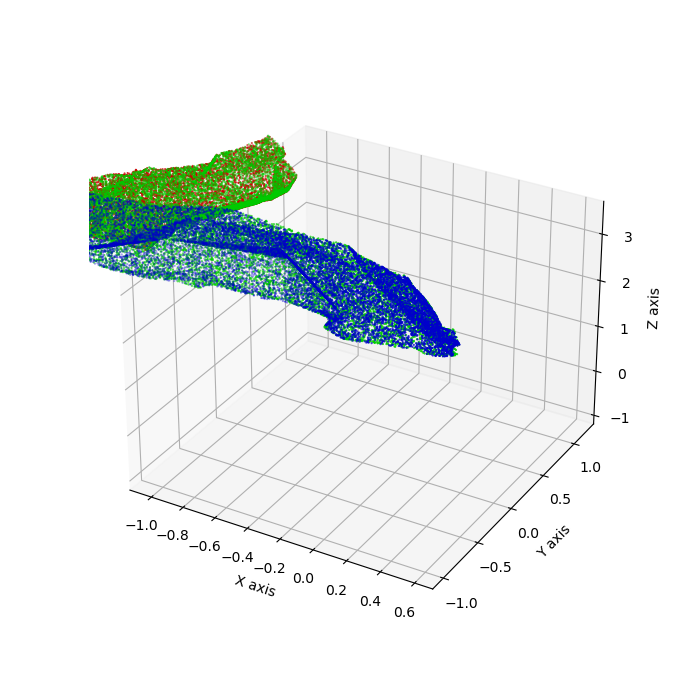

In [30]:
show_point_clouds(pcs)